In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ray

from mdps.cliff import ContextualCliff
from utils.distributions import ConstantDistribution, ParticleDistribution

# Contextual "cliff"

This notebook studies using particle filtering to estimate the context parameters of a standard `Cliff` environment in `mdps.cliff`.

The `Cliff` environment has a cart that chooses either to go left or right for a `step_size`. It starts at the `mid_point` of the `right_end` and the `left_end`, and it receives a reward proportional to the power (default set to 2) of its current location, `x`. If it "falls off the cliff" from the left or right end, however, it receives a highly negative reward and the episode ends. Also, there are noise and drift terms, and the state-transition equation of the position `x` is (where `action` is 0 or 1 for moving left or right):
\
$x_{t+1} = N(0, \text{noise}) - \text{drift} * x + 2 * (\text{action}-0.5) * \text{stepsize}$

Thus, the goal of the cart is to keep its position `x` as large as possible (i.e. close to the larger end) and in the meantime keep a distance to that end to prevent accidentally falling off due to the transition noise.

The context params are: `(left_bound, right_bound, pow, step_size, noise, drift)`.

# Set target

We first create a target config, $c$. This will be the $MDP(c)$ the expert uses to generate the observational data.

In [2]:
# true (expert) context: (left_bound, right_bound, pow, step_size, noise, drift) =
#                         [0.0, 3.0, 2.0, 0.05, 0.05, 0.0]
c = {'context_distribution':
         ConstantDistribution(dim=6,
                              constant_vector=np.array([0.0, 3.0, 2, 0.05, 0.05, 0.0]))}

First, train an expert that masters this context.

In [3]:
from ray.rllib.agents import ppo

ray.shutdown()
ray.init()
expert = ppo.PPOTrainer(env=ContextualCliff, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(25):
    res = expert.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-02-13 23:50:04,170	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8265
2022-02-13 23:50:05,383	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-02-13 23:50:05,383	INFO trainer.py:745 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-02-13 23:50:06,827	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 -90.02790690443832
5 167.306938687172
10 315.274336510315
15 313.02161322082907
20 342.2732290259531


In [4]:
# collect expert rollout
env = ContextualCliff(config=c)
done = False
obs = env.reset()
# run until episode ends
gt_obs_arr = None
gt_act_arr = None
while not done:
    action = expert.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    if gt_obs_arr is None:
        gt_obs_arr = obs
        gt_act_arr = [action]
    else:
        gt_obs_arr = np.vstack((gt_obs_arr, obs))
        gt_act_arr += [action]

gt_act_arr = np.array(gt_act_arr)

In [5]:
gt_obs_arr.shape

(100, 7)

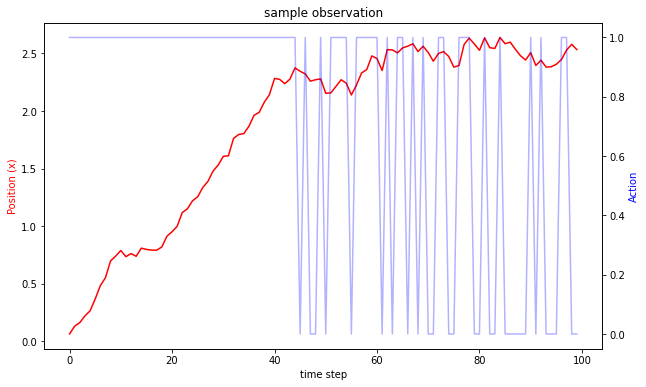

In [6]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 6, forward=True)

x = np.arange(start=0, stop=gt_obs_arr.shape[0])
ax2 = ax1.twinx()
ax1.plot(x, gt_obs_arr[:, 0], 'r-')
ax2.plot(x, gt_act_arr, 'b-', alpha=0.3)

ax1.set_xlabel('time step')
ax1.set_ylabel('Position (x)', color='r')
ax2.set_ylabel('Action', color='b')
plt.title('sample observation')
plt.show()

## Exact context

We first train a RL solver only on the correct context for particle filtering. We have already done this so we can directly use the expert solver.

In [7]:
# true (expert) context: (left_bound, right_bound, pow, step_size, noise, drift) =
#                       [0.0, 3.0, 2.0, 0.025, 0.05, 0.0]

N = 2000
T = 100
left_bound = np.random.normal(loc=0, scale=0.001, size=(N,))
right_bound = np.random.normal(loc=2.5, scale=0.5, size=(N,))
pow = np.ones((N,)) * 2
step_size = np.ones((N,)) * 0.025
noise = np.ones((N,)) * 0.05
drift = np.random.normal(loc=0.00, scale=0.001, size=(N,))

context_particles = np.vstack((left_bound, right_bound, pow, step_size, noise, drift)).T
context_particles = np.abs(context_particles)
context_distribution = ParticleDistribution(dim=6, particles=context_particles, n_particles=N)

In [8]:
solver = expert
state_arr = np.zeros((N,))
action_arr = np.zeros((N,))
context_history = []
for t in range(T):
    # we only use the first 5 steps of the cartpole steps to reduce effect of different episode lengths
    qs = np.zeros((N,))
    for n in range(N):
        context = context_distribution.particles[n]
        if context[4] < 0:
            qs[n] = 0
            state_arr[n] = np.copy(env.mdp.x)
            continue
        c_local = {'context_distribution':
                       ConstantDistribution(dim=6,
                                            constant_vector=context)}
        env = ContextualCliff(config=c_local)
        done = False
        obs = env.reset()
        if t > 0:
            env.mdp.x = state_arr[n]
            obs = np.concatenate((np.array([env.mdp.x]), context), axis=0).flatten()
        action = solver.compute_single_action(obs)
        obs, reward, done, info = env.step(action)
        # estimate likelihood if r >= 1
        if t >= 1:
            q = env.likelihood(gt_obs_arr[t - 1], action_arr[n], obs)
            qs[n] = q
        state_arr[n] = np.copy(env.mdp.x)
        action_arr[n] = action
    if t >= 1:
        # truncated importance sampling; [https://arxiv.org/pdf/1905.09800.pdf]
        qs = np.clip(qs, 0, np.percentile(qs, 90))
        qs = qs / qs.sum()
        resample_index = context_distribution.resample_particles_from_probability(p=qs)
        p_temp = context_distribution.particles
        pnoise = np.random.normal(loc=0, scale=p_temp.std(axis=0), size=p_temp.shape) * 0.05
        context_distribution.particles += pnoise
        state_arr = state_arr[resample_index]
        action_arr = action_arr[resample_index]
    if t % 10 == 0:
        print(t, context_distribution.particles[:, 1].mean())
    context_history += [context_distribution.particles.copy()]

0 2.5086934395022644
10 2.4631432743813213
20 2.364222710721165
30 2.3825816319089173
40 2.697994056725329
50 2.790044778196844
60 2.835314015260862
70 2.984356790367391
80 3.0203674764476873
90 2.9505041268694203


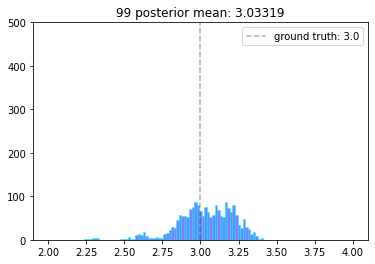

In [9]:
from matplotlib import animation

HIST_BINS = np.linspace(2, 4, 120)

def prepare_animation(bar_container_):
    def animate(frame_number, data=context_history):
        # simulate new data coming in
        x = data[frame_number][:, 1]
        n, _ = np.histogram(x, HIST_BINS)
        plt.title(f'{frame_number} posterior mean: {round(x.mean(), 5)}')
        for count, rect in zip(n, bar_container_.patches):
            rect.set_height(count)
        return bar_container_.patches

    return animate


fig, ax = plt.subplots()
plt.axvline(x=3, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 3.0'])
_, _, bar_container = ax.hist(context_history[0][:, 1], HIST_BINS, lw=1,
                              ec="cyan", fc="blue", alpha=0.5)
ax.set_ylim(top=N / 4)  # set safe limit to ensure that all data is visible.

ani = animation.FuncAnimation(fig, prepare_animation(bar_container), len(context_history),
                              repeat=True, blit=False, interval=100, repeat_delay=500)
prior_mean = 2.5
posterior_mean = round(context_history[-1][:, 1].mean(), 3)
ani.save(f'prior_{prior_mean}_posterior{posterior_mean}.mp4', dpi=300)
plt.show()

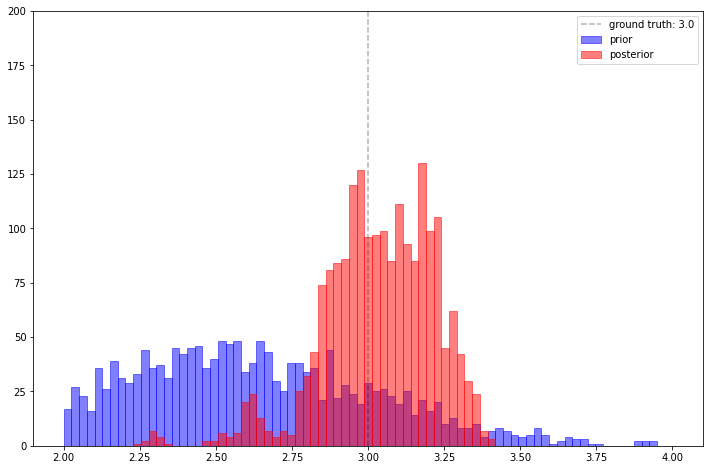

In [10]:
fig, ax = plt.subplots()
HIST_BINS = np.linspace(2, 4, 80)
ax.hist(context_history[0][:, 1], HIST_BINS, lw=1,
                              ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history[-1][:, 1], HIST_BINS, lw=1,
                              ec="red", fc="red", alpha=0.5)
plt.axvline(x=3, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 3.0', 'prior', 'posterior'])
ax.set_ylim(top=N / 10)
fig.set_size_inches(12, 8)
plt.show()

# Mis-specified context

We also see what happens if we train a solver only on an MDP $MDP(c_{miss})$, where $c_{miss}$ is a mis-specified context.

We can see the estimation result is much worse (bias and variance look large) than using the solver in the correctly specified context.

In [12]:
# We reduce the right end from 3.0 to 1.5 and keep otherwise the same.
c_mis = {'context_distribution':
             ConstantDistribution(dim=5,
                                  constant_vector=np.array([0.0, 2, 2.0, 0.025, 0.05, 0.0]))}

ray.shutdown()
ray.init()
mis_solver = ppo.PPOTrainer(env=ContextualCliff, config={
    "env_config": c_mis,
    "framework": "torch",  # config to pass to env class
})

for eps in range(25):
    res = mis_solver.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])

2022-02-13 23:58:47,190	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8265
2022-02-13 23:58:49,642	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 -94.13601431359511
5 -3.796653184149934
10 19.82127788500557
15 18.964521550315133
20 33.88917130476306


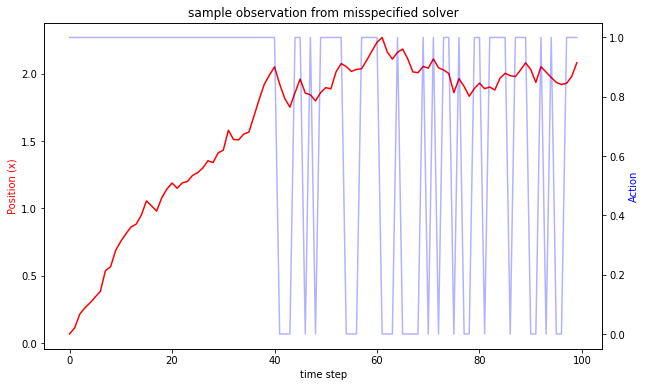

In [13]:
# collect expert rollout
env = ContextualCliff(config=c)
done = False
obs = env.reset()
# run until episode ends
mis_obs_arr = None
mis_act_arr = None
while not done:
    action = mis_solver.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    if mis_obs_arr is None:
        mis_obs_arr = obs
        mis_act_arr = [action]
    else:
        mis_obs_arr = np.vstack((mis_obs_arr, obs))
        mis_act_arr += [action]

mis_act_arr = np.array(mis_act_arr)

fig, ax1 = plt.subplots()
fig.set_size_inches(10, 6, forward=True)

x = np.arange(start=0, stop=mis_obs_arr.shape[0])
ax2 = ax1.twinx()
ax1.plot(x, mis_obs_arr[:, 0], 'r-')
ax2.plot(x, mis_act_arr, 'b-', alpha=0.3)

ax1.set_xlabel('time step')
ax1.set_ylabel('Position (x)', color='r')
ax2.set_ylabel('Action', color='b')
plt.title('sample observation from misspecified solver')
plt.show()

In [14]:
# true (expert) context: (left_bound, right_bound, pow, step_size, noise, drift) =
#                       [0.0, 3.0, 2.0, 0.025, 0.05, 0.0]

N = 2000
T = 100
left_bound = np.random.normal(loc=0, scale=0.001, size=(N,))
right_bound = np.random.normal(loc=2.5, scale=0.5, size=(N,))
pow = np.ones((N,)) * 2
step_size = np.ones((N,)) * 0.025
noise = np.ones((N,)) * 0.05
drift = np.ones((N,)) * 0

context_particles = np.vstack((left_bound, right_bound, pow, step_size, noise, drift)).T
context_particles = np.abs(context_particles)
context_distribution = ParticleDistribution(dim=6, particles=context_particles, n_particles=N)

In [15]:
solver = mis_solver
state_arr = np.zeros((N,))
action_arr = np.zeros((N,))
context_history = []
for t in range(T):
    # we only use the first 5 steps of the cartpole steps to reduce effect of different episode lengths
    qs = np.zeros((N,))
    for n in range(N):
        context = context_distribution.particles[n]
        if context[4] < 0:
            qs[n] = 0
            state_arr[n] = np.copy(env.mdp.x)
            continue
        c_local = {'context_distribution':
                       ConstantDistribution(dim=6,
                                            constant_vector=context)}
        env = ContextualCliff(config=c_local)
        done = False
        obs = env.reset()
        if t > 0:
            env.mdp.x = state_arr[n]
            obs = np.concatenate((np.array([env.mdp.x]), context), axis=0).flatten()
        action = solver.compute_single_action(obs)
        obs, reward, done, info = env.step(action)
        # estimate likelihood if r >= 1
        if t >= 1:
            q = env.likelihood(gt_obs_arr[t - 1], action_arr[n], obs)
            qs[n] = q
        state_arr[n] = np.copy(env.mdp.x)
        action_arr[n] = action
    if t >= 1:
        # truncated importance sampling; [https://arxiv.org/pdf/1905.09800.pdf]
        qs = np.clip(qs, 0, np.percentile(qs, 90))
        qs = qs / qs.sum()
        resample_index = context_distribution.resample_particles_from_probability(p=qs)
        p_temp = context_distribution.particles
        pnoise = np.random.normal(loc=0, scale=p_temp.std(axis=0), size=p_temp.shape) * 0.05
        context_distribution.particles += pnoise
        state_arr = state_arr[resample_index]
        action_arr = action_arr[resample_index]
    if t % 10 == 0:
        print(t, context_distribution.particles[:, 1].mean())
    context_history += [context_distribution.particles.copy()]

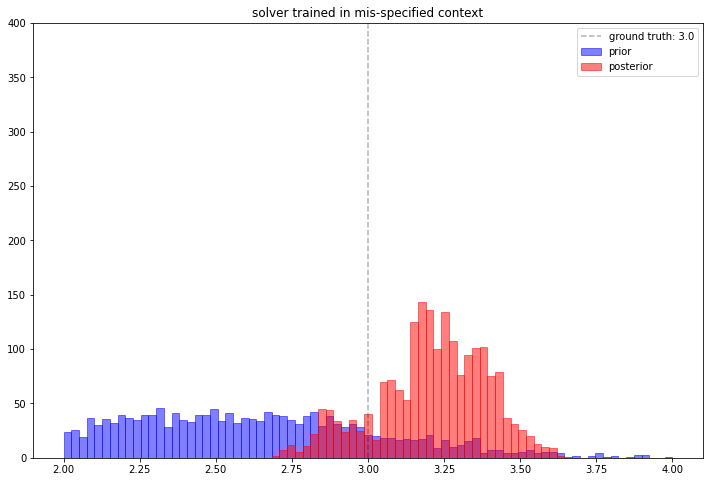

In [17]:
fig, ax = plt.subplots()
HIST_BINS = np.linspace(2, 4, 80)
ax.hist(context_history[0][:, 1], HIST_BINS, lw=1,
                              ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history[-1][:, 1], HIST_BINS, lw=1,
                              ec="red", fc="red", alpha=0.5)
plt.axvline(x=3, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 3.0', 'prior', 'posterior'])
ax.set_ylim(top=N / 5)
fig.set_size_inches(12, 8)
plt.title('solver trained in mis-specified context')
plt.show()

# Uniformly sampled context

We uniformly sample contexts during training, a common way to perform domain randomization.

In [ ]:
#TODO c_uniform = ?